In [1]:
%matplotlib inline
%load_ext lab_black

nb_samples = 30
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features = len(list_features)
flow = "162-216"
runway = "14"

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from traffic.core import Traffic
from artefact import Autoencoder
from artefact.clustering import get_latent
from artefact.training import train
from artefact.plot import plot_loss, plot_latent, plot_latent_and_trajs

t = Traffic.from_file(f"data/lszh_{flow}_{runway}.parquet")
X = np.load(f"data/lszh_{flow}_{runway}.npy")
model_ = Autoencoder((nb_samples * nb_features, 32, 8, 2))
device = 0

/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:294: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance(name, collections.Sequence):


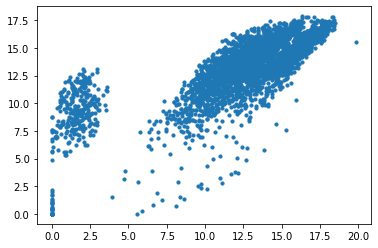

In [3]:
model, loss = train(
    model_, X, device=device, nb_iterations=10000, batch_size=len(X), lambda_kl=0
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_ae_10000.pth")
plot_latent(X, model, device)

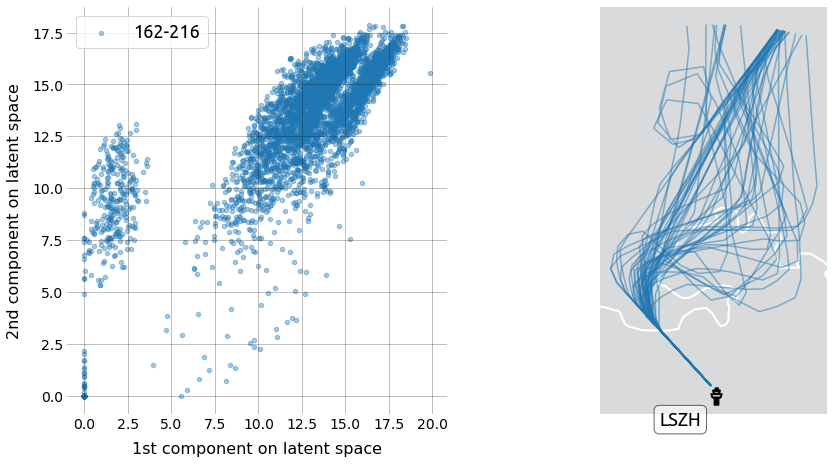

In [4]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_ae_10000.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, f"figs/{flow}_{runway}_latent_ae.png", runway=14)

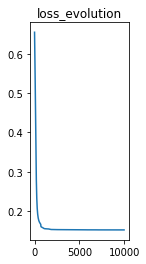

In [5]:
plot_loss(loss["loss"])

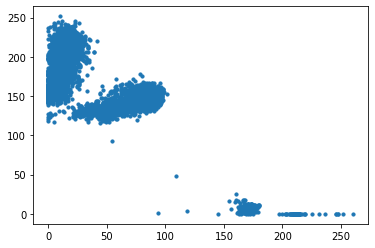

In [10]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.05
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_tsne_500_005.pth")
plot_latent(X, model, device)

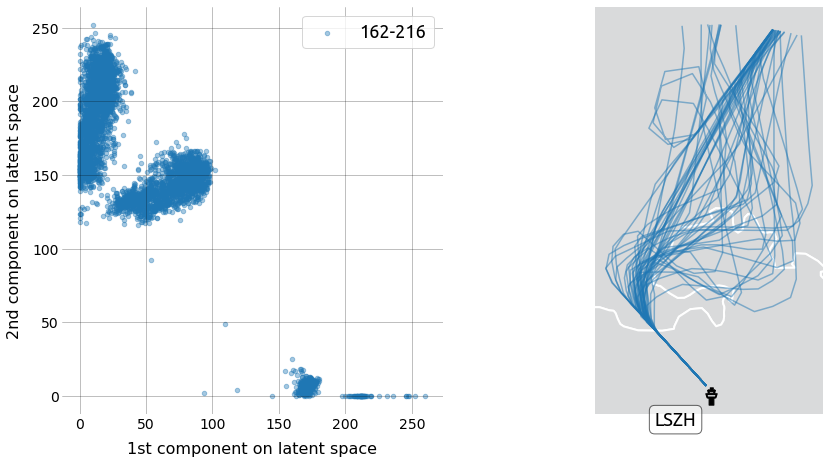

In [12]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_tsne_500_005.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(
    t, lat, f"figs/{flow}_{runway}_latent_tsne_500_005.png", runway=14
)

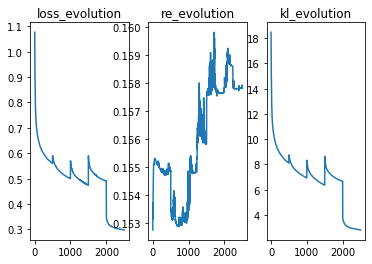

In [13]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

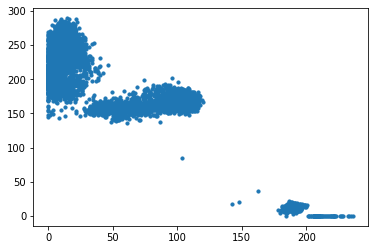

In [14]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.01
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_tsne_500_001.pth")
plot_latent(X, model, device)

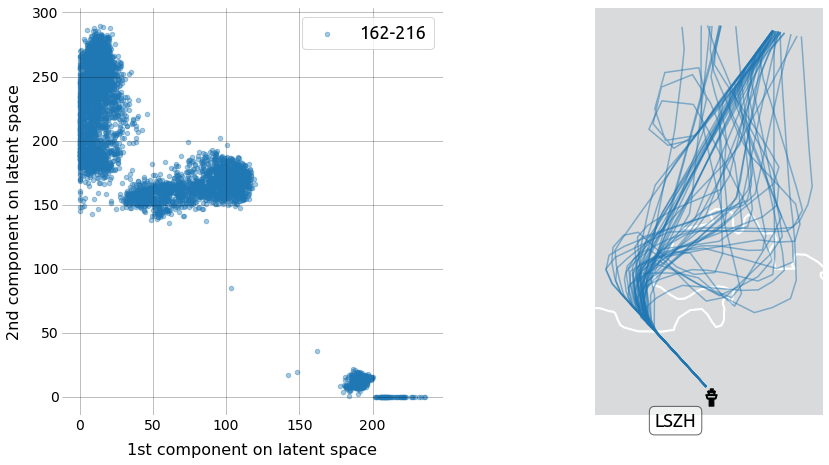

In [15]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_tsne_500_001.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(
    t, lat, f"figs/{flow}_{runway}_latent_tsne_500_001.png", runway=14
)

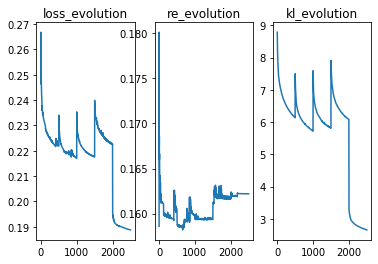

In [17]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

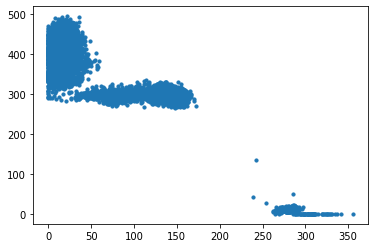

In [18]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.07
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_tsne_500_007.pth")
plot_latent(X, model, device)

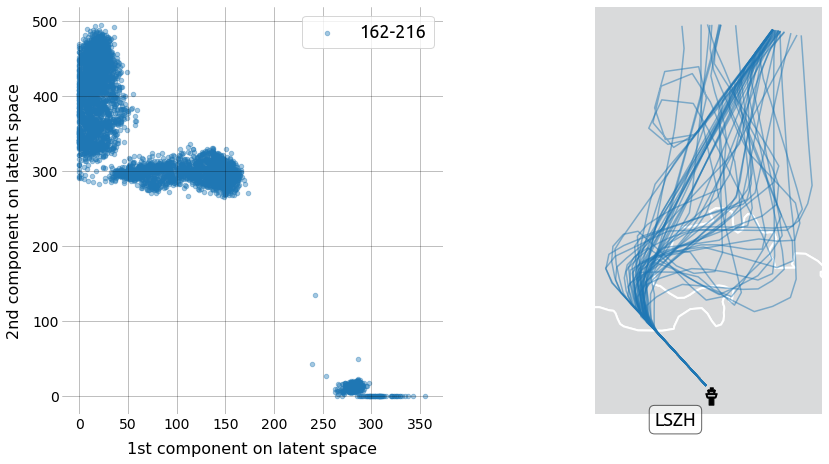

In [19]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_tsne_500_007.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, f"figs/{flow}_{runway}_latent_tsne.png", runway=14)

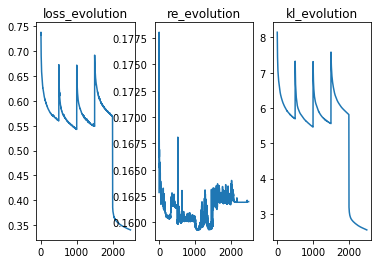

In [20]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from traffic.core import Traffic

from artefact import AutoencoderTSNE, Autoencoder

t = Traffic.from_file(f"data/lszh_{flow}_{runway}.parquet")
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
# list_features = ["longitude", "latitude"]

nb_flights = len(t)
nb_samples = len(t[0])
nb_features = len(list_features)
lambda_kl = 0.7
print(f"nb_flights: {len(t)}")

device = 2

algo_clustering = AutoencoderTSNE(
    gpu=device,
    batch_size=1000,
    model=Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    lambda_kl=lambda_kl,
    nb_iterations=800,
    algo_clustering=GaussianMixture(n_components=4),
    distance_trajectory="euclidean",  # delta_max
    savepath=f"models/model_{flow}_{runway}.pth",
)
model = algo_clustering.model

t_tsne = t.clustering(
    nb_samples=None,
    features=list_features,
    clustering=algo_clustering,
    transform=MinMaxScaler(feature_range=(-1, 1)),
).fit_predict()

t_tsne.to_pickle(f"test/t_tsne_{flow}_{runway}.pkl")
t_tsne.groupby(["cluster"]).agg({"flight_id": "nunique"})

nb_flights: 4437


,flight_id
cluster,
0,1721
1,1474
2,357
3,885


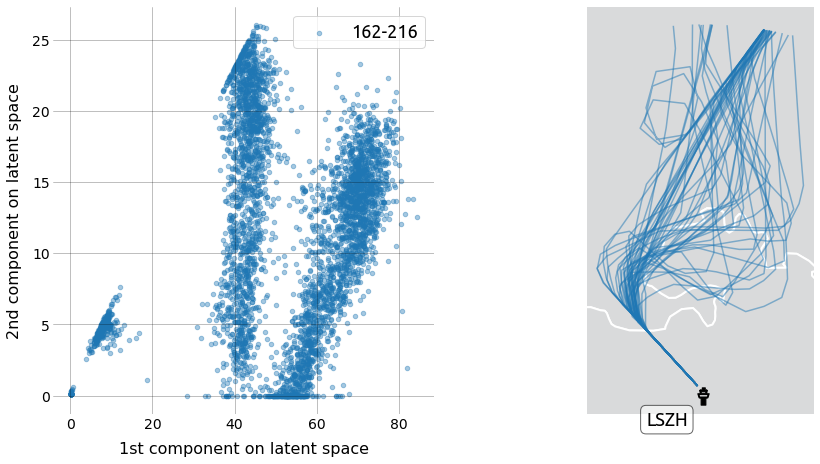

In [7]:
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t, algo_clustering.get_latent(), f"figs/{flow}_{runway}_latent.png", runway=14
)

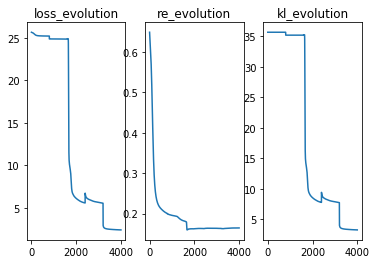

In [8]:
from artefact.plot import plot_loss

loss = algo_clustering.loss
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

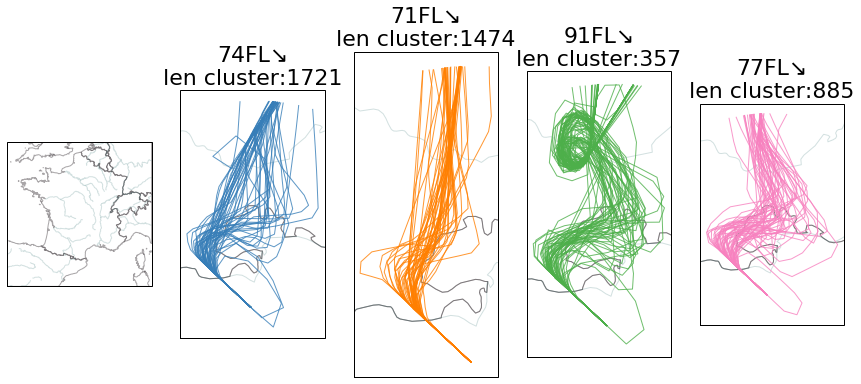

In [9]:
from traffic.core import Traffic
from artefact.plot import plot_trajs

t_tsne = Traffic.from_file(f"test/t_tsne_{flow}_{runway}.pkl")
plot_trajs(t_tsne, None)

        flight_id        re                    
          nunique      mean       min       max
cluster                                        
-1            417  0.171874  0.013691  0.705130
 0           1536  0.127815  0.000000  0.669343
 1           2136  0.159820  0.000741  1.000000
 2            285  0.161731  0.045407  0.322875
 3             63  0.407923  0.290287  0.611877


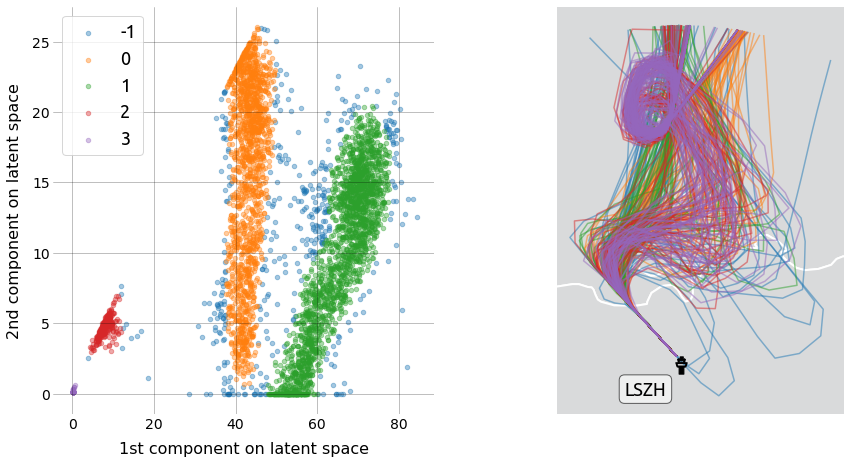

In [10]:
from sklearn.cluster import DBSCAN
from artefact import Autoencoder
from artefact.utils import pretrained_clust

eps, min_samples = 1.6, 40


def eps_f(eps):
    return str(eps).replace(".", "")


ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    DBSCAN(eps=eps, min_samples=min_samples),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_dbscan_{flow}_{runway}.pkl",
)
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t_tsne,
    ae_tsne.get_latent(),
    f"figs/{flow}_{runway}_latent_clusters_dbscan_{eps_f(eps)}_{min_samples}.png",
    plot_clusters=True,
    runway=14,
)

        flight_id        re                    
          nunique      mean       min       max
cluster                                        
0            1475  0.199807  0.044609  0.411381
1            1720  0.127600  0.000000  0.705130
2             885  0.105721  0.000741  1.000000
3             357  0.205635  0.045407  0.611877


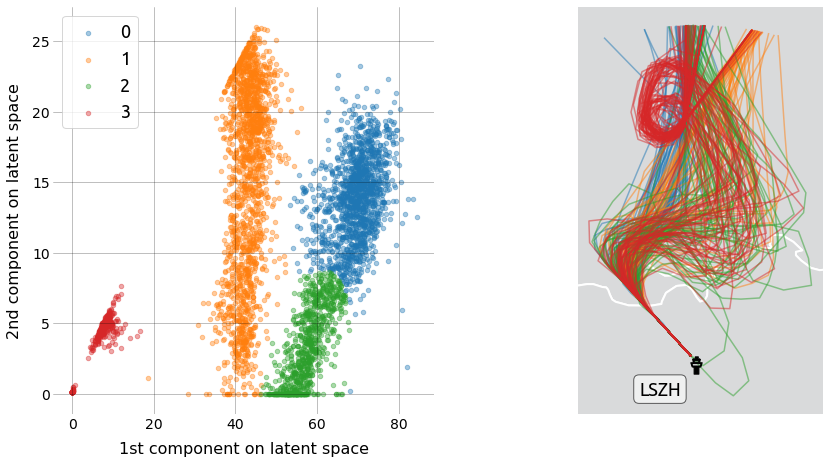

In [11]:
from sklearn.mixture import GaussianMixture
from artefact import Autoencoder
from artefact.utils import pretrained_clust

ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    GaussianMixture(n_components=4),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_gm_{flow}_{runway}.pkl",
)
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t_tsne,
    ae_tsne.get_latent(),
    f"figs/{flow}_{runway}_latent_clusters_gm.png",
    plot_clusters=True,
    runway=14,
)

In [12]:
# adding GM probability score
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from traffic.core import Traffic

t_tsne = Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl")
X = np.load(f"data/lszh_{flow}_{runway}.npy")
gm = GaussianMixture(n_components=4)
labels = gm.fit_predict(X)
scores = gm.score_samples(X)
scores = (
    MinMaxScaler(feature_range=(0, 1)).fit_transform(scores.reshape(-1, 1)).flatten()
)
t_tsne_scores = pd.DataFrame.from_records(
    [dict(flight_id=f.flight_id, prob=score) for f, score in zip(t_tsne, scores)]
)
t_tsne_scores = t_tsne.merge(t_tsne_scores, on="flight_id")
print(
    t_tsne_scores.groupby(["cluster"]).agg(
        {
            "flight_id": "nunique",
            "re": ["mean", "min", "max"],
            "prob": ["mean", "min", "max"],
        }
    )
)

        flight_id        re                          prob                    
          nunique      mean       min       max      mean       min       max
cluster                                                                      
0            1475  0.199807  0.044609  0.411381  0.953855  0.000000  1.000000
1            1720  0.127600  0.000000  0.705130  0.900861  0.202535  0.983257
2             885  0.105721  0.000741  1.000000  0.854681  0.249570  0.980464
3             357  0.205635  0.045407  0.611877  0.794295  0.647979  0.842960


221
        flight_id        re                    
          nunique      mean       min       max
cluster                                        
0             117  0.299393  0.270617  0.411381
1              15  0.412998  0.269871  0.705130
2              19  0.432860  0.291071  1.000000
3              70  0.398624  0.270666  0.611877


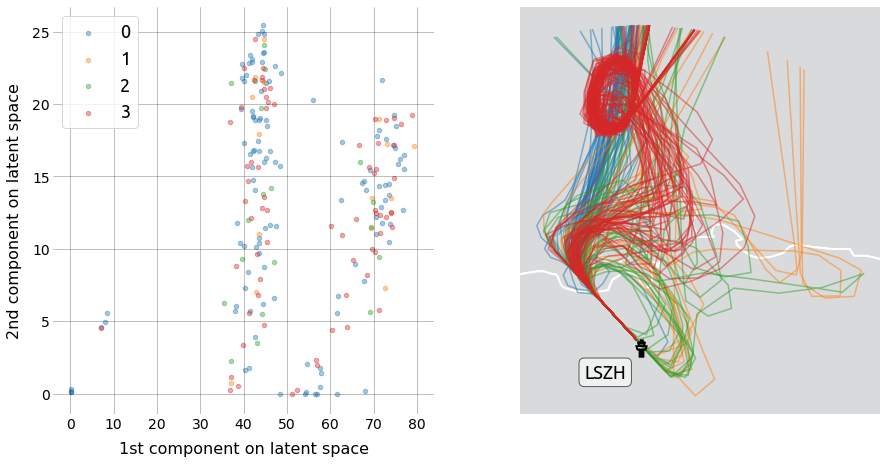

In [13]:
# outliers based on reconstruction error (re)
import numpy as np
from artefact.plot import plot_latent_and_trajs

re = t_tsne_scores.data.re
threshold = np.percentile(re, 95)
outliers = Traffic.from_flights(
    f for f in t_tsne_scores if f.data.re.mean() > threshold
)

print(len(outliers))
print(
    outliers.groupby(["cluster"]).agg(
        {"flight_id": "nunique", "re": ["mean", "min", "max"]}
    )
)

plot_latent_and_trajs(
    outliers,
    ae_tsne.get_latent(),
    f"figs/{flow}_{runway}_latent_clusters_outliers_re_gm.png",
    plot_clusters=True,
    runway=14,
)

In [14]:
def clust_duration_cumdist(t):
    durations = pd.DataFrame.from_records(
        [
            dict(flight_id=f.flight_id, duration=d)
            for f, d in zip(t, [f.duration.seconds // 60 for f in t])
        ]
    )
    return (
        t.merge(durations, on="flight_id")
        .cumulative_distance(False)
        .eval(max_workers=10)
        .groupby("cluster")
        .agg({"flight_id": "nunique", "duration": "mean", "cumdist": "mean"})
    )

In [15]:
dur_dist = clust_duration_cumdist(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl")
)
dur_dist

,flight_id,duration,cumdist
cluster,,,
0,1475,11.074576,25.019608
1,1720,12.926744,27.899726
2,885,14.674576,30.401245
3,357,20.330532,41.118506


In [16]:
clust_duration_cumdist(outliers)

,flight_id,duration,cumdist
cluster,,,
0,117,10.572650,25.177766
1,15,23.800000,47.610665
2,19,23.052632,48.077207
3,70,25.157143,50.812141


In [17]:
def clust_duration_cumdist(t):
    durations = pd.DataFrame.from_records(
        [
            dict(flight_id=f.flight_id, duration=d)
            for f, d in zip(t, [f.duration.seconds // 60 for f in t])
        ]
    )
    return (
        t.merge(durations, on="flight_id")
        .cumulative_distance(False)
        .eval(max_workers=10)
        .groupby("flight_id")
        .mean()
        .reset_index()
    )[["flight_id", "cluster", "duration", "cumdist"]]


import altair as alt


def dur_dist_plot(dur_dist):
    return (
        alt.Chart(dur_dist)
        .transform_density(
            "duration", as_=["duration", "density"], extent=[5, 60], groupby=["cluster"]
        )
        .mark_area(orient="horizontal")
        .encode(
            y="duration:Q",
            color="cluster:N",
            x=alt.X(
                "density:Q",
                stack="center",
                impute=None,
                title=None,
                axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
            ),
            column=alt.Column(
                "cluster:N",
                header=alt.Header(
                    titleOrient="bottom", labelOrient="bottom", labelPadding=0,
                ),
            ),
        )
        .properties(width=100)
        .configure_facet(spacing=0)
        .configure_view(stroke=None)
    )

In [18]:
dur_dist = clust_duration_cumdist(outliers)
dur_dist_plot(dur_dist)

alt.Chart(...)

In [19]:
dur_dist = clust_duration_cumdist(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl")
)
dur_dist_plot(dur_dist)

alt.Chart(...)